In [183]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [184]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [185]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [186]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [187]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [188]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [189]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [190]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [191]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(most_recent_date)

2017-08-23


In [201]:
#date = most_recent_date - dt.timedelta(days=365)
#print("12 months ago: ", date)
#sel = [Measurement.date, Measurement.prcp]
#year_data = session.query(*sel).filter(Measurement.date > date).all()
#print(year_data)

end_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
#print(end_date)
start_date = end_date - dt.timedelta(days=365)
#print(start_date)
sel = [Measurement.date, Measurement.prcp]
year_data = session.query(*sel).filter(Measurement.date >= start_date, Measurement.date <= most_recent_date).all()
#print(year_data)
precipitation = pd.DataFrame(year_data, columns=['Date','Inches'])
precipitation.sort_values('Date', inplace=True)
precipitation['Date'] = pd.to_datetime(Precipitation['Date'])
print(Precipitation['Date'])

0      2016-08-23
1009   2016-08-23
1529   2016-08-23
704    2016-08-23
361    2016-08-23
          ...    
1527   2017-08-22
1008   2017-08-23
360    2017-08-23
1528   2017-08-23
2229   2017-08-23
Name: Date, Length: 2230, dtype: datetime64[ns]


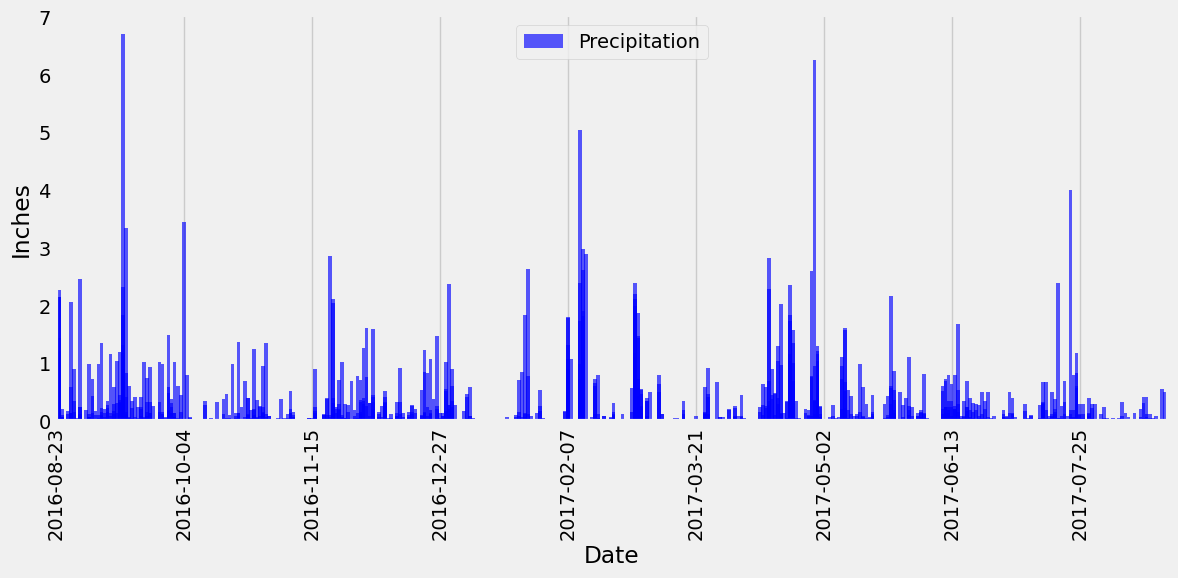

In [194]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
#early_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print("12 months ago: ", date)
import matplotlib.dates as mdates

#most_recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
#most_recent_date = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')
#start_date = most_recent_date - dt.timedelta(days=365)
start_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date() - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]

year_data = session.query(*sel).filter(Measurement.date >= start_date, Measurement.date <= most_recent_date).all()



# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(year_data, columns=['Date','Inches'])


# Sort the dataframe by date
#do not use set-index bc therre may be repeated precipitation values so that could lead to duplicate data
precipitation['Date'] = pd.to_datetime(Precipitation['Date'])
precipitation.sort_values('Date', inplace=True)


bar_width = 1.2
plt.figure(figsize=(12, 6))
plt.bar(Precipitation['Date'], Precipitation['Inches'], width=bar_width, color='b', alpha=0.65, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)

#date_format = [date.strftime("%Y-%m-%d") for date in Precipitation['Date']]
#plt.gca().set_xticklabels(date_format)

plt.xlim(pd.to_datetime(start_date), pd.to_datetime(most_recent_date))  # Convert start_date and most_recent_date to datetime objects

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(loc='upper center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [195]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = Precipitation["Inches"].describe().reset_index()
stats.columns = ['Precipitation', ' ']
stats.set_index('Precipitation', inplace=True) 
stats

,
Precipitation,
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [196]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(total_stations)

9


In [197]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#import sqlalchemy import func

most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count'))
most_active_stations = most_active_stations.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
#print(most_active_stations)
for station, count in most_active_stations:
    #print(f"Station:{station}. Count: {count}")
    print([((station),(count))])



[('USC00519281', 2772)]
[('USC00519397', 2724)]
[('USC00513117', 2709)]
[('USC00519523', 2669)]
[('USC00516128', 2612)]
[('USC00514830', 2202)]
[('USC00511918', 1979)]
[('USC00517948', 1372)]
[('USC00518838', 511)]


In [198]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station == "USC00519281").all()
print(most_active)


[(54.0, 85.0, 71.66378066378067)]


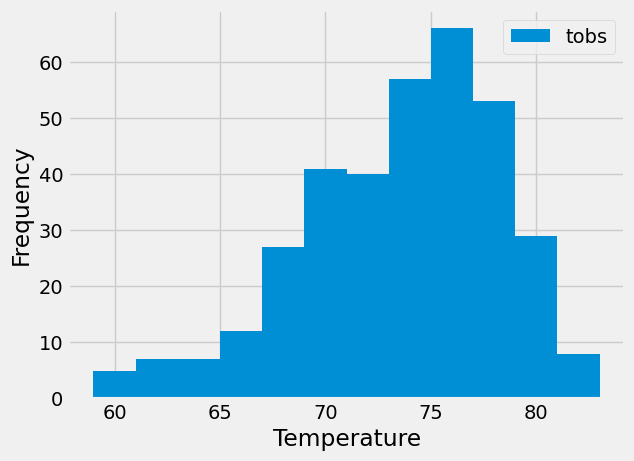

In [199]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

begin_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date() - dt.timedelta(days=365)


twelve_months_data = session.query(Measurement.tobs).filter(Measurement.date >= begin_date, Measurement.date <= most_recent_date, Measurement.station == "USC00519281").all()



# Save the query results as a Pandas DataFrame. Explicitly set the column names
temperature = pd.DataFrame(twelve_months_data, columns=['Temperature'])


plt.hist(Temperature['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Close Session

In [200]:
# Close Session
session.close()